<a href="https://colab.research.google.com/github/liesemarques/covid_kaggle/blob/main/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pipeline 01

1. **Data acquisition**
* Arquivo json disponibilizado pelo kaggle - https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge
2. **Extração e limpeza**
* Criação do DataFrame
* Pré processamento e limpeza
3. **Amostra da base**
* Foram extraidos 500 artigos 
4. **Função de pre-processamento**
* Tokenization
* Lowercasing - Substituição das palavras maiusculas em minusculas
* Lemmatization - Lemmatization reduz as palavras em lemmas, nas formas básicas das palavras Ex: 'Smoking' para 'Smoke'
* Remoção das StopWords, Pontos, Espaços e numeros
6. **Pesquisa com spaCy**
* Imprimindo textos com palavras encontradas
7. **Similaridade entre strings com fuzzywuzzy**
* Comparação com o texto completo
* Comparação com o abstract






# Pipeline 02

## Data Acquisition

## Text Extraction and Cleanup
* HTML Parsing and Cleanup
* Unicode Normalization
* Spelling Correction

## Pre-Processing

para essa etapa precisamos dividir um texto em palavras e frases, retirar pontos, virgulas espaços em branco e converter as palavras em 'lowercase' 

* Sentence segmentation and word tokenization
NLP software analiza os textos dividindo em palavras (tokens) e sentençassenten
* StopWord removal, stemming and lemmatization, removing digits/punctuation, lowercasing
* POS tagging, parsing, coreference resolution, etc

## Feature Engineering

## Modeling

## Evaluation

## Pos Modeling Phases

* Deployment
* Monitoring
* Model Updateing



# Carregando as bibliotecas

In [ ]:
import numpy as np
import zipfile
import pandas as pd
import glob
import json
import seaborn as sns
import spacy
import nltk
from IPython.core.display import HTML
from matplotlib import pyplot as plt

In [ ]:
# !pip install spacy==2.2

In [ ]:
# https://allenai.github.io/scispacy/
!pip install scispacy

In [ ]:
# Pacote python contendo modelos spacy para processar textos biomedicos
import scispacy

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.5/en_core_sci_md-0.2.5.tar.gz

In [ ]:
import en_core_sci_md

In [ ]:
!python -m spacy download en

# Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/MyDrive/Covid/archive.zip'
zip_object = zipfile.ZipFile(file=path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

# Extração dos textos
## Criação do DataFrame

In [ ]:
corona_features = {'paper_id': [], 'title': [],
                   'abstract': [], 'text': []}

corona_df = pd.DataFrame.from_dict(corona_features)

In [ ]:
 json_files = glob.glob(f'{"/content/document_parses"}//**/*.json',recursive=True )


In [ ]:
len(json_files)

222496

In [ ]:
for json_f in json_files:
  with open(json_f) as json_data:
    data = json.load(json_data)

In [ ]:
def return_corona_df(json_filenames, df):
  for file_names in json_filenames:
    row= {'paper_id':None, 'title':None,'abstract': None, 'text': None }
  
    with open(file_names) as json_data:
 
      data = json.load(json_data)

      if 'paper_id' not in data:
        row['paper_id'] = np.nan
      else:
        row['paper_id'] = data['paper_id'].strip() 
      
      if 'metadata' not in data:
        row['metadata'] = np.nan
      else:  
        row['title'] = data['metadata']['title'].strip()
        
      if 'abstract' not in data:
        row['abstract'] = np.nan
      else:
        abstract_list = [abstract['text'] for abstract in data['abstract']]
        abstract = '\n '.join(abstract_list)
        row['abstract'] = abstract.strip()
   
      if 'body_text' not in data:
        row['body_text'] = np.nan
      else:
        text_list = [text['text'] for text in data['body_text']]
        text = '\n '.join(text_list)
        row['text'] = text.strip()

        df = df.append(row, ignore_index = True)
  return df   


In [ ]:
corona_df = return_corona_df(json_files , corona_df)

In [ ]:
corona_df.to_csv('/content/gdrive/MyDrive/Covid/corona_df.csv', index=False)

# Pré processamento e limpeza

In [ ]:
corona_df = pd.read_csv('/content/gdrive/MyDrive/Covid/corona_df.csv')

In [ ]:
corona_df.shape

(127120, 4)

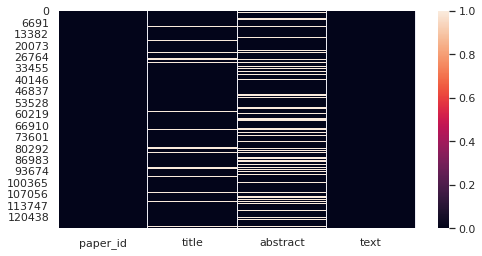

In [ ]:
# https://seaborn.pydata.org/examples/spreadsheet_heatmap.html
sns.set(rc={'figure.figsize': (8,4)})
sns.heatmap(corona_df.isnull())

In [ ]:
nulos = corona_df[corona_df['abstract'].isnull()].copy()

,paper_id,title,abstract,text
3,8754c53bfffdc51cf75c266efb63c812d1acf7cf,SARS-CoV-2 infection in children with febrile ...,NaN,No other site of infection was found in our pa...
10,406e0c9944f89fe36eaedde0a94baae2d0d2f773,NaN,NaN,Fueron seleccionados 316 recién nacidos. Se re...
11,55764385538698096e0fad96b76e16028857b3c0,Suspension of Hip Surveillance for Children wi...,NaN,The severe acute respiratory syndrome coronavi...
15,173beac57d53fd54df0d5dc48db9260118b21a35,COVID-19 infection in patients with Sézary syn...,NaN,"A pandemic coronavirus, severe acute respirato..."
20,9af75b5b77b68d3760c42b72d41135136fa95030,Glycyrrhizic acid derivatives as Dengue virus ...,NaN,Dengue virus (DENV) is one of the most geograp...
...,...,...,...,...
127105,f953c4073576d368a3e0bb54b97fbe82ff275b28,The impact of COVID-19 and other pandemics and...,NaN,"I, the Submitting Author has the right to gran..."
127107,991aa431678e06eed1c6719debb62c8f1080f087,Coronavirus disease 2019: new things to know!,NaN,"In this review, the median age in the differen..."
127110,57149de9f084a10c7c6388c685bde4a3836e674a,Thirty-day mortality following surgical manage...,NaN,The COVID-19 outbreak is an ongoing global pan...
127112,feaf8123a34a8b7c46be61719675b7753b1b7552,NaN,NaN,"intervention is deemed necessary, the dentist ..."


In [ ]:
lista_null = []
for id, row in nulos.iterrows():
  lista_null.append(row['paper_id'])

In [ ]:
print(lista_null[66])

dea8dd7596fcea6c8d1702f9a437b229fd189643


In [ ]:
for i in corona_df.columns:
    print(f"Dados faltantes em {i} = {len(corona_df[corona_df[i] == ''])}")

Dados faltantes em paper_id = 0
Dados faltantes em title = 0
Dados faltantes em abstract = 0
Dados faltantes em text = 0


In [ ]:
for i in corona_df.columns:
  corona_df = corona_df[corona_df[i].notnull()]

In [ ]:
corona_df.isnull().sum()

paper_id    0
title       0
abstract    0
text        0
dtype: int64

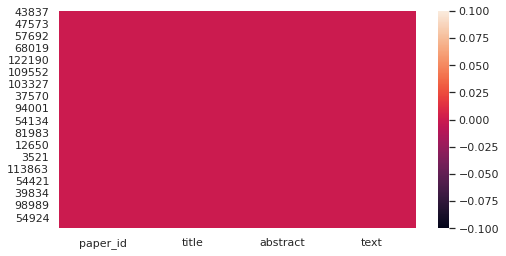

In [ ]:
sns.set(rc={'figure.figsize': (8,4)})
sns.heatmap(corona_df.isnull())

In [ ]:
corona_df.drop_duplicates(['abstract','text','title'], inplace = True)

In [ ]:
corona_df.shape

(323, 4)

In [ ]:
# corona_df.to_csv('/content/gdrive/MyDrive/Covid/corona_df.csv', index=False)

# Amostra da base

In [ ]:
corona_df = corona_df.sample(n=500, random_state=1)

In [ ]:
corona_df.head()

,paper_id,title,abstract,text
43837,dc2cb01b95e4dfe628d807ec614d077370a4c58b,Journal Pre-proof Clinical considerations for ...,Managing out-of-hospital cardiac arrest requir...,The COVID-19 pandemic has been associated with...
65404,905b4a6c82eae2c7990e51780e5efaf1ddc21850,"A rapid, high-volume cervical screening projec...","Objective: Rapid, high-volume screening progra...",Infection with human papillomavirus (HPV) is a...
95749,fee162ad06d96d264269ad41ff8b12d77b84caee,Comment,NaN,Many governments are looking for paths out of ...
69230,d729ec4af90b62b3fd52c5e79c868955213a70f2,Detection of hepatitis E virus and other lives...,Manure application is a source of pathogens to...,a b s t r a c t a r t i c l e i n f o\n Runoff...
123280,a27adabfa89d32df634f7e7a9a6056b36ded5031,"Citation: Human, Nonhuman Primate, and Bat Cel...",NaN,The viral order Mononegavirales currently incl...


# Função de pre-processamento
* Tokenization -- https://spacy.io/usage/linguistic-features#tokenization
* Lowercasing - Substituição das palavras maiusculas em minusculas
* Lemmatization - Lemmatization reduz as palavras em lemmas, nas formas básicas das palavras Ex: 'Smoking' para 'Smoke'
* StopWords

In [ ]:
nlp = spacy.load("en_core_sci_md",disable=["tagger", "parser"])
nlp.max_length = 2000000

In [ ]:
nlp_ent = spacy.load("en")
nlp_ent.max_length = 2000000

In [ ]:
# Algumas palavras encontradas na nuvem de palavras que não estavam nas stop word do spacy
new_stop_words = ['et', 'al', 'doi', 'copyright', 'http', 'https', 'fig', 'table', 'result', 'show']
for word in new_stop_words:
  nlp.vocab[word].is_stop = True

In [ ]:
def spacy_token(sentence):
  sentence = sentence.lower()
  lista = []
  lista = [word.lemma_ for word in nlp(sentence) if not (word.is_stop or # Remoção das stopwords
                                                         word.like_num or # Remoção dos numeros
                                                         word.is_punct or # Remoção dos pontos
                                                         word.is_space or # Remoção dos espaços
                                                         len(word) == 1)]


  lista = ' '.join(text for text in lista)
  return lista

In [ ]:
# Aplicando a função spacy_token na amostra com 500 artigos
corona_df['text'] = corona_df['text'].apply(spacy_token)

# Visualização dos paises e cidades mais citados em artigos

In [ ]:
text = corona_df['text'][126220]
doc = nlp_ent(text)

In [ ]:
from spacy import displacy
displacy.render(doc, style="ent", jupyter=True)

In [ ]:
# https://spacy.io/api/annotation
for i in doc.ents:
  if i.label_ == 'GPE' or i.label_ == 'NORP':
    print(i.text, i.label_)

french NORP
uk GPE
london GPE
french NORP
london GPE
british NORP
london GPE
london GPE
england GPE
london GPE
australian NORP
qaly GPE
england GPE
qaly GPE
uk GPE
uk GPE
london GPE
australian NORP
qaly GPE
australian NORP
uk GPE
japan GPE
canadian NORP
china GPE


In [ ]:
gpe = []
for index, col in corona_df.iterrows():
  text = col['text']
  doc = nlp_ent(text)
  for ent in doc.ents:
    if ent.label_ == 'GPE':
      gpe.append(str(ent.text))

In [ ]:
len(gpe)

6436

In [ ]:
values_gpe, counts_gpe = np.unique(np.array(gpe), return_counts = True)

In [ ]:
gpe_df = pd.DataFrame({'value': values_gpe, 'counts': counts_gpe})

In [ ]:
gpe_df_filtered = gpe_df[gpe_df.counts > 70]

In [ ]:
gpe_df_filtered.head(16)

,value,counts
229,china,605
483,germany,116
572,hong kong,134
629,india,225
657,italy,86
668,japan,117
897,mrna,258
953,neutrophil,108
1234,sirna,107
1248,south korea,77


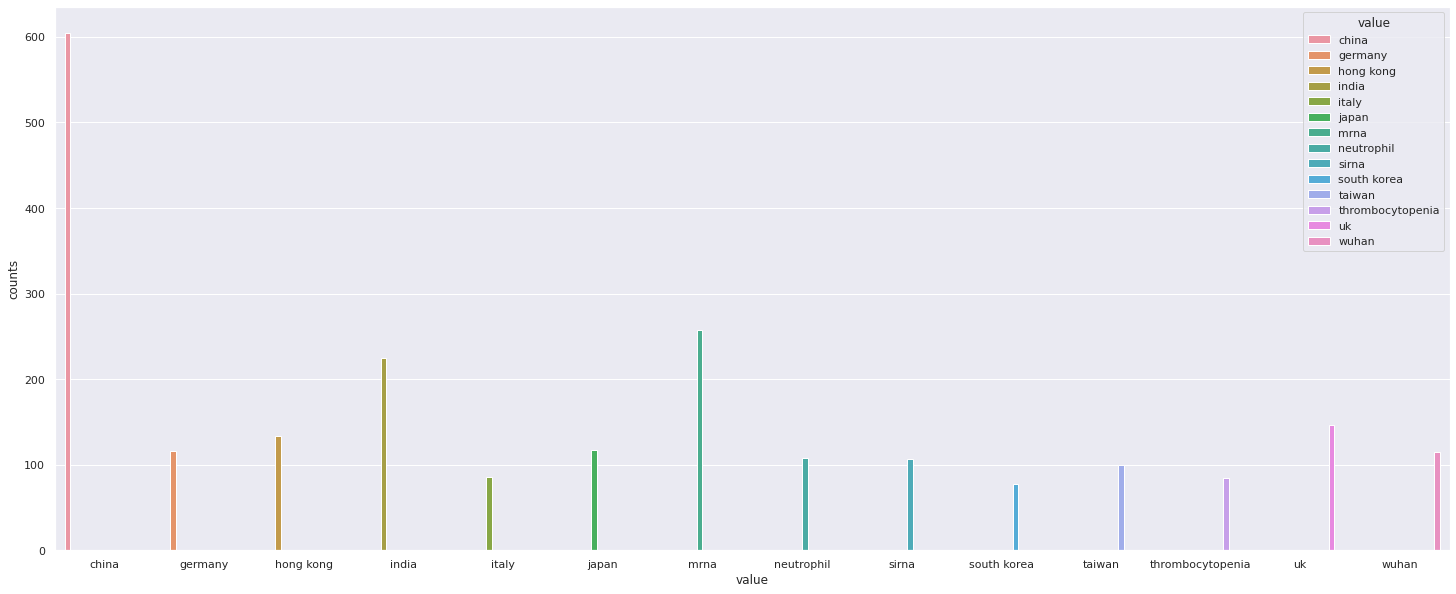

In [ ]:
sns.set(rc={'figure.figsize': (25,10)})
sns.barplot(x = 'value', y = 'counts', hue='value', data=gpe_df_filtered);

# Visualização das palavras mais frequentes

In [ ]:
from matplotlib.colors import ListedColormap
color_map = ListedColormap(['orange', 'green', 'red', 'magenta'])

In [ ]:
from wordcloud import WordCloud
cloud = WordCloud(background_color = 'white', max_words=100, colormap=color_map)

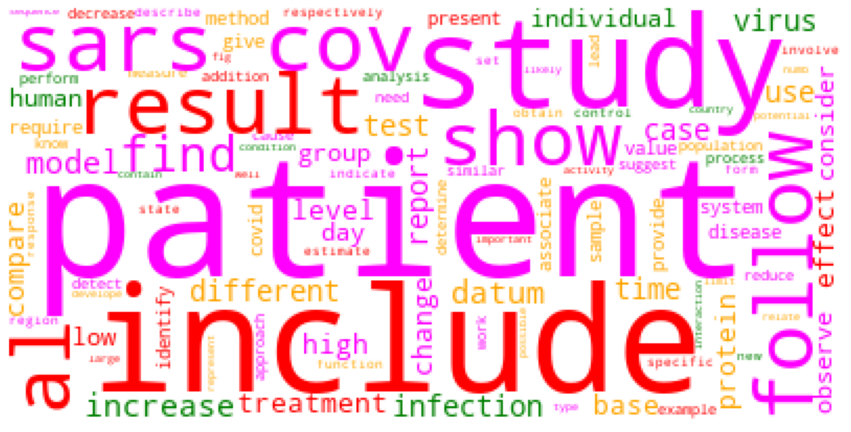

In [ ]:
cloud = cloud.generate(corona_df['text'].str.cat(sep='\n'))
plt.figure(figsize=(15,15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

# Pesquisa com spaCy

In [ ]:
search_strings = ['Smoking','pulmonary disease']
tokens_list = [nlp(spacy_token(item)) for item in search_strings]
tokens_list

[smoke, pulmonary disease]

In [ ]:
# https://spacy.io/api/matcher
from spacy.matcher import PhraseMatcher
matcher = PhraseMatcher(nlp.vocab)
matcher.add('SEARCH', None, *tokens_list)
numbers_of_words = 50

## Teste 'matcher'
matcher retorna uma lista de tuplas com o codigo seguido da posição da palavra encontrada

In [ ]:
text = 'group obscure potentially important relationship large study power detect past smoke observe significant difference time smoke cessation organism'
text

'group obscure potentially important relationship large study power detect past smoke observe significant difference time smoke cessation organism'

In [ ]:
doc = nlp(text)
matchers = matcher(doc)
matchers

[(8661325627334373315, 10, 11), (8661325627334373315, 15, 16)]

In [ ]:
# Para visualozar a palavra encontrada
doc[15:16]

smoke

In [ ]:
doc[5-15:16+5]

detect past smoke observe significant difference time smoke cessation organism

In [ ]:
search_string_html = ' '.join([str(element) for element in search_strings])

## Imprimindo textos com palavras encontradas

In [ ]:
for index, row in corona_df.iterrows():
    marked_text = ''
    doc = nlp(row['text'])
    paper_id = row['paper_id']
    title = row['title']
    matches = matcher(doc)
    if matches == []:
        continue
    display(HTML(f'<h1>{search_string_html.upper()}</h1>'))
    display(HTML(f"""<p>
                      <strong>Titulo:</strong> {title}</br>
                      <strong>ID:</strong> {paper_id}</br>
                      <strong>Numero de vezes:</strong> {len(matches)}
                     </p>"""))
    for i in matches:
        start = i[1] - numbers_of_words
        if start < 0 :
            start = 0
        for j in range(len(tokens_list)):
            if doc[i[1]:i[2]].similarity(tokens_list[j]) == 1.0:
                search_text = str(tokens_list[j])
                marked_text = str(doc[start:i[2] + numbers_of_words]).replace(search_text, f"<mark>{search_text}</mark>")
                marked_text += "<br /><br /> "
    display(HTML(f"""<blockquote>...{marked_text}...</blockquote>"""))   

# Similaridade entre strings com fuzzywuzzy

In [ ]:
!pip install fuzzywuzzy

In [ ]:
!pip install python-Levenshtein

In [ ]:
from fuzzywuzzy import fuzz

## Comparação com o texto completo

In [ ]:
# search_string = 'Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases. Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments'
# search_string = 'What do we know about vaccines and therapeutics'
search_string = 'Effectiveness of drugs being developed and tried to treat COVID-19 patients'
# search_string = 'Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication'

In [ ]:
search_string = spacy_token(search_string)
print(search_string)

effectiveness drug develope try treat covid-19 patient


## Comparação com o text

In [ ]:

ratio = [] # Similaridade da string em ordem
partial_ratio = [] # Similaridade da string parcial
sort_ratio = [] # Ignora a ordem das palavras
set_ratio = [] # Ignora palavras duplicadas
for index, row in corona_df.iterrows():
  ratio.append(fuzz.ratio(row['text'], search_string))
  partial_ratio.append(fuzz.partial_ratio(row['text'], search_string))
  sort_ratio.append(fuzz.token_sort_ratio(row['text'], search_string))
  set_ratio.append(fuzz.token_set_ratio(row['text'], search_string))

In [ ]:
func = [ratio, partial_ratio, sort_ratio, set_ratio ]
for i in func:
  print(f'A media de similaridade entre os textos é {np.array(i).mean()}') 


A media de similaridade entre os textos é 2.906
A media de similaridade entre os textos é 45.01
A media de similaridade entre os textos é 2.902
A media de similaridade entre os textos é 37.36


## Comparação com o abstract

In [ ]:
corona_df['abstract'] = corona_df['abstract'].apply(spacy_token)

In [ ]:
ratio = [] # Similaridade da string em ordem
partial_ratio = [] # Similaridade da string parcial
sort_ratio = [] # Ignora a ordem das palavras
set_ratio = [] # Ignora palavras duplicadas
for index, row in corona_df.iterrows():
  ratio.append(fuzz.ratio(row['abstract'], search_string))
  partial_ratio.append(fuzz.partial_ratio(row['abstract'], search_string))
  sort_ratio.append(fuzz.token_sort_ratio(row['abstract'], search_string))
  set_ratio.append(fuzz.token_set_ratio(row['abstract'], search_string))

In [ ]:
func = [ratio, partial_ratio, sort_ratio, set_ratio ]
for i in func:
  print(f'A media de similaridade entre os abstract é {np.array(i).mean()}') 

A media de similaridade entre os abstract é 36.366
A media de similaridade entre os abstract é 43.55
A media de similaridade entre os abstract é 37.49
A media de similaridade entre os abstract é 42.852


## Retorno dos artigos mais similares

In [ ]:
scores = { }
for index, row in corona_df.iterrows():
  scores[row['paper_id']] = fuzz.partial_ratio(row['text'], search_string)

In [ ]:
# Ordenou com os maiores score
import operator
soted_score = sorted(scores.items(), key=operator.itemgetter(1), reverse=True)

In [ ]:
pd.set_option('display.max_colwidth', -1)
display(HTML(f'<h3>{search_string.upper()}</h3></br>'))
for i in soted_score[:10]:
  df = corona_df[corona_df['paper_id'] == i[0]]
  display(HTML(f"""<p>
                     <strong>Titulo:</strong> {df['title']}</br>
                     <strong>ID:</strong> {i[0]}</br>
                     <strong>Score:</strong> {i[1]}</br>
                     <strong>Abstract:</strong> {str(df['abstract'])[0:700]}</br>
                     <strong>Text:</strong> {str(df['text'])[0:700]}
                  </p> </br></br>"""))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.
